#### import data

In [1]:
import pandas as pd  
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
data = pd.read_json('twitter_labeled_v2.json', lines =True)

In [3]:
len(data)

66035

In [4]:
data.isnull().sum()

favorite       0
language       0
magnitude    331
polarity       0
reply          0
retweet        0
score        331
text           0
time           0
dtype: int64

#### tranform label to binary vector [1,0,0] [0,1,0] [0,0,1] neg neural pos

In [19]:
data = data.drop(data.score[data.score.isnull()].index)# delete rows that api don't give the result
#(in this data 331 twitter don't have result)

In [20]:
len(data)

65704

#### score < -0.5 strong negative; score < 0 and score >= -0.5 negative; score == 0 neutral; score > 0 and score <= 0.5 positive; score > 0.5 strong positive

In [21]:
def get_label_value(score):
    if score < -0.5:
        return 0
    if score < 0 and score >= -0.5:
        return 1
    if score == 0:
        return 2
    if score > 0 and score <= 0.5:
        return 3
    if score > 0.5:
        return 4
data['label_value'] = data['score'].apply(get_label_value)

In [111]:
with open('final_twitter.json', 'w') as f:
    f.write(data.to_json(orient='records', lines=True))

In [22]:
from sklearn.preprocessing import label_binarize

y = label_binarize(data['label_value'], classes=[0, 1, 2,3,4])

In [72]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(data['label_value'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

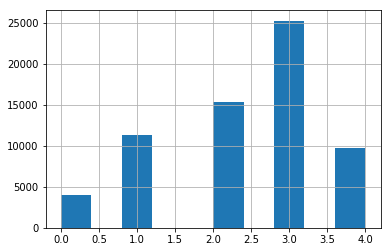

In [50]:
data.label_value.hist()# the data is not balance and most of twitters are positive or neutral

#### without emnbedding use tfidf vector as input nodes build a fully connected network

In [65]:
y[:5]

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D,Conv1D, MaxPooling1D, Embedding

Using TensorFlow backend.


In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tf_vec = tfidf.fit_transform(data.text)

In [24]:
tf_vec.shape[1]

27639

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_vec, y, test_size=0.2, random_state=2)

In [22]:
X_train.shape,y_train.shape

((52563, 27639), (52563, 5))

In [32]:
#build first nerual network
model1 = Sequential()

model1.add(Dense(128, activation = 'relu', input_shape = (tf_vec.shape[1],)))

model1.add(Dropout(0.2))
model1.add(Dense(64, activation = 'relu'))
model1.add(Dense(5, activation='sigmoid'))

In [33]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               3537920   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 325       
Total params: 3,546,501
Trainable params: 3,546,501
Non-trainable params: 0
_________________________________________________________________


In [34]:
model1.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])

In [35]:
x_val = X_train[:2000]
partial_x_train = X_train[2000:]
y_val = y_train[:2000]
partial_y_train = y_train[2000:]

In [36]:
result = model1.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 50563 samples, validate on 2000 samples
Epoch 1/20
50563/50563 [==============================] - 19s 370us/step - loss: 0.4653 - acc: 0.8082 - val_loss: 0.3902 - val_acc: 0.8291
Epoch 2/20
50563/50563 [==============================] - 18s 361us/step - loss: 0.3450 - acc: 0.8458 - val_loss: 0.3435 - val_acc: 0.8425
Epoch 3/20
50563/50563 [==============================] - 18s 361us/step - loss: 0.3005 - acc: 0.8671 - val_loss: 0.3281 - val_acc: 0.8498
Epoch 4/20
50563/50563 [==============================] - 18s 362us/step - loss: 0.2713 - acc: 0.8819 - val_loss: 0.3222 - val_acc: 0.8537
Epoch 5/20
50563/50563 [==============================] - 18s 359us/step - loss: 0.2471 - acc: 0.8941 - val_loss: 0.3213 - val_acc: 0.8562
Epoch 6/20
50563/50563 [==============================] - 18s 361us/step - loss: 0.2265 - acc: 0.9041 - val_loss: 0.3239 - val_acc: 0.8591
Epoch 7/20
50563/50563 [==============================] - 18s 360us/step - loss: 0.2076 - acc: 0.9141 - val_loss: 0.3

In [37]:
model1.evaluate(X_test, y_test, verbose=0)[1]

0.85001140537621922

#### amazing!  the orignial model i use 30000 twitter , labeld from paralleldots api(only give pos neg neu) the result is 80%

#### build  a CNN model with embedding, padding layers, using keras tokenizer get input nodes

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### keras tokenlzer: fit_on_texts(data.text):get vocabulary list with each index
#####tokenizer.texts_to_sequences: rebuild each sentence with word index

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
sequences = tokenizer.texts_to_sequences(data.text)

In [68]:
data.text[0]

'waves community launches "guess the seed" competition win 500 waves tokens!'

In [66]:
sequences[0]

[1402, 176, 1685, 658, 1, 5630, 1566, 119, 199, 1402, 54]

In [40]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'and': 3,
 'is': 4,
 'a': 5,
 '…': 6,
 'for': 7,
 'you': 8,
 'in': 9,
 'of': 10,
 'i': 11,
 'on': 12,
 'it': 13,
 'this': 14,
 'get': 15,
 'will': 16,
 'be': 17,
 'your': 18,
 'now': 19,
 'twitter': 20,
 'with': 21,
 'com': 22,
 'free': 23,
 'are': 24,
 'that': 25,
 'up': 26,
 'at': 27,
 'buy': 28,
 'all': 29,
 'more': 30,
 'verge': 31,
 'we': 32,
 'join': 33,
 'my': 34,
 'if': 35,
 'have': 36,
 'pic': 37,
 'just': 38,
 'so': 39,
 'coin': 40,
 'not': 41,
 'here': 42,
 'time': 43,
 'new': 44,
 'what': 45,
 'like': 46,
 'crypto': 47,
 'but': 48,
 'out': 49,
 'can': 50,
 'has': 51,
 'about': 52,
 'do': 53,
 'tokens': 54,
 'people': 55,
 'as': 56,
 'coins': 57,
 'me': 58,
 'or': 59,
 'xvg': 60,
 'from': 61,
 'bonus': 62,
 'when': 63,
 'some': 64,
 '1': 65,
 'go': 66,
 'they': 67,
 'going': 68,
 'good': 69,
 'no': 70,
 'see': 71,
 'by': 72,
 '100': 73,
 'pre': 74,
 'token': 75,
 '0': 76,
 'one': 77,
 "it's": 78,
 'price': 79,
 '2018': 80,
 'its': 81,
 'best': 82,
 'sel

In [41]:
max([len(x) for x in sequences])


61

### the highest word number in a twitter list is 65. pad other sentence with 0 value to make every sentence have same length

In [42]:
x_model2 = pad_sequences(sequences, maxlen=65)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_model2, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [44]:
embedding_dim = 200#set word vector'length
word_count = len(tokenizer.word_index)

In [46]:
model2 = Sequential()
model2.add(Embedding(word_count + 1, embedding_dim, input_length=65))
model2.add(Dropout(0.2))
model2.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is 60
model2.add(MaxPooling1D(3))
model2.add(Flatten())
model2.add(Dense(200, activation='relu'))
model2.add(Dense(5, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 200)           5864200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 65, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 63, 250)           150250    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 250)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5250)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               1050200   
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 1005      
Total para

In [47]:
model2.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result2 = model2.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 51s 960us/step - loss: 0.3900 - acc: 0.8288 - val_loss: 0.3218 - val_acc: 0.8540
Epoch 2/20
53219/53219 [==============================] - 51s 960us/step - loss: 0.2971 - acc: 0.8648 - val_loss: 0.2928 - val_acc: 0.8661
Epoch 3/20
53219/53219 [==============================] - 51s 967us/step - loss: 0.2554 - acc: 0.8870 - val_loss: 0.2891 - val_acc: 0.8682
Epoch 4/20
53219/53219 [==============================] - 51s 963us/step - loss: 0.2241 - acc: 0.9041 - val_loss: 0.3008 - val_acc: 0.8660
Epoch 5/20
53219/53219 [==============================] - 50s 948us/step - loss: 0.1956 - acc: 0.9187 - val_loss: 0.3068 - val_acc: 0.8647
Epoch 6/20
53219/53219 [==============================] - 51s 949us/step - loss: 0.1674 - acc: 0.9320 - val_loss: 0.3332 - val_acc: 0.8571
Epoch 7/20
53219/53219 [==============================] - 51s 952us/step - loss: 0.1391 - acc: 0.9457 - val_loss: 0.3

In [48]:
model2.evaluate(X_test, y_test, verbose=0)[1]

0.84486377577570504

#### combined wordvec2 with cnn

#### because I build two wordvec2 model based on have stop words or not,so I should build a embedding layers by my self

##### single word wordvec2 model

In [12]:
from gensim.models import Word2Vec
import gensim
import re

C:\Users\TEMP\Anaconda3\envs\nlp\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [25]:
wv2single = gensim.models.word2vec.Word2Vec.load("singleword2v.w2v")
wv2_single_voc = list(wv2single.wv.vocab.keys())
wv2_single_voc_dict = dict(zip(wv2_single_voc,list(range(len(wv2_single_voc)))))
wv2_single_sequences = []
for text in data.text:
    temp_vec = []
    for word in text.split():
        if word in wv2_single_voc:
            temp_vec.append(wv2_single_voc_dict[word])
    wv2_single_sequences.append(temp_vec)

In [26]:
wv2single.wv.most_similar('good')

[('great', 0.8452621102333069),
 ('nice', 0.7789426445960999),
 ('forward', 0.7583998441696167),
 ('bad', 0.6935279369354248),
 ('amazing', 0.6809878349304199),
 ('positive', 0.656152069568634),
 ('awesome', 0.6407425403594971),
 ('better', 0.639358401298523),
 ('pretty', 0.632267951965332),
 ('big', 0.6230407953262329)]

In [27]:
len(wv2_single_voc)

6646

In [28]:
len(wv2_single_sequences)

65704

In [29]:
max([len(a) for a in wv2_single_sequences])

41

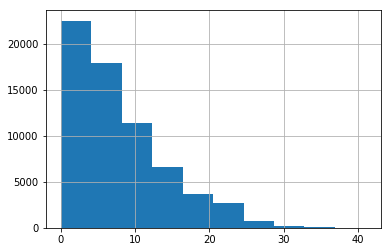

In [30]:
pd.Series([len(a) for a in wv2_single_sequences]).hist()

In [31]:
x_model3 = pad_sequences(wv2_single_sequences, maxlen=45)

In [32]:
embedding_matrix = np.zeros((len(wv2_single_voc_dict)+ 1, 100))
for word,index in wv2_single_voc_dict.items():
    embedding_matrix[index] = wv2single.wv[word]

In [33]:
embedding_matrix.shape

(6647, 100)

In [34]:
embedding_layer = Embedding(len(wv2_single_voc_dict)+ 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=45,
                            trainable=False)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(x_model3, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [36]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.2))
model3.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
#model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 100)           664700    
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 43, 250)           75250     
_________________________________________________________________
flatten_2 (Flatten)          (None, 10750)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1075100   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 1,815,555
Trainable params: 1,150,855
Non-trainable params: 664,700
____________________________________________________________

In [37]:
model3.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result3 = model3.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 16s 297us/step - loss: 0.4439 - acc: 0.8151 - val_loss: 0.3857 - val_acc: 0.8284
Epoch 2/20
53219/53219 [==============================] - 16s 293us/step - loss: 0.3834 - acc: 0.8287 - val_loss: 0.3766 - val_acc: 0.8305
Epoch 3/20
53219/53219 [==============================] - 16s 291us/step - loss: 0.3708 - acc: 0.8346 - val_loss: 0.3729 - val_acc: 0.8327
Epoch 4/20
53219/53219 [==============================] - 15s 289us/step - loss: 0.3604 - acc: 0.8399 - val_loss: 0.3684 - val_acc: 0.8368
Epoch 5/20
53219/53219 [==============================] - 15s 291us/step - loss: 0.3513 - acc: 0.8440 - val_loss: 0.3695 - val_acc: 0.8334
Epoch 6/20
53219/53219 [==============================] - 15s 291us/step - loss: 0.3422 - acc: 0.8486 - val_loss: 0.3717 - val_acc: 0.8360
Epoch 7/20
53219/53219 [==============================] - 16s 295us/step - loss: 0.3335 - acc: 0.8531 - val_loss: 0.3

In [38]:
model3.evaluate(X_test, y_test, verbose=0)[1]

0.82319282579233322

#### use a single word model that have stop words

In [87]:
wv2single = gensim.models.word2vec.Word2Vec.load("nofilter.w2v")
wv2_single_voc = list(wv2single.wv.vocab.keys())
wv2_single_voc_dict = dict(zip(wv2_single_voc,list(range(len(wv2_single_voc)))))
wv2_single_sequences = []
for text in data.text:
    temp_vec = []
    
    for word in text.split():
        if word in wv2_single_voc:
            temp_vec.append(wv2_single_voc_dict[word])
    wv2_single_sequences.append(temp_vec)


In [88]:
len(wv2_single_voc)

8992

In [89]:
max([len(a) for a in wv2_single_sequences])

60

In [90]:
x_model3 = pad_sequences(wv2_single_sequences, maxlen=60)

In [92]:
embedding_matrix = np.zeros((len(wv2_single_voc_dict)+ 1, 200))
for word,index in wv2_single_voc_dict.items():
    embedding_matrix[index] = wv2single .wv[word]

In [93]:
embedding_matrix.shape

(8993, 200)

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_model3, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [95]:
embedding_layer = Embedding(len(wv2_single_voc_dict)+ 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=60,
                            trainable=False)


In [96]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.2))
model3.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model3.add(MaxPooling1D(3))
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 60, 200)           1798600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 200)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 58, 250)           150250    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 250)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4750)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               475100    
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 505       
Total para

In [98]:
model3.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result3 = model3.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 31s 577us/step - loss: 0.3380 - acc: 0.8502 - val_loss: 0.3545 - val_acc: 0.8447
Epoch 2/20
53219/53219 [==============================] - 31s 575us/step - loss: 0.3238 - acc: 0.8570 - val_loss: 0.3564 - val_acc: 0.8443
Epoch 3/20
53219/53219 [==============================] - 31s 574us/step - loss: 0.3117 - acc: 0.8624 - val_loss: 0.3556 - val_acc: 0.8458
Epoch 4/20
53219/53219 [==============================] - 31s 575us/step - loss: 0.2992 - acc: 0.8694 - val_loss: 0.3695 - val_acc: 0.8392
Epoch 5/20
53219/53219 [==============================] - 31s 575us/step - loss: 0.2869 - acc: 0.8755 - val_loss: 0.3741 - val_acc: 0.8414
Epoch 6/20
53219/53219 [==============================] - 31s 576us/step - loss: 0.2745 - acc: 0.8819 - val_loss: 0.3766 - val_acc: 0.8423
Epoch 7/20
53219/53219 [==============================] - 30s 573us/step - loss: 0.2629 - acc: 0.8875 - val_loss: 0.3

In [99]:
model3.evaluate(X_test, y_test, verbose=0)[1]

0.82051437503579294

#### use pretrained glove model

In [5]:
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

In [8]:
glove_twitter.wv.most_similar('good')

C:\Users\TEMP\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('great', 0.8672515749931335),
 ('well', 0.8378019332885742),
 ('nice', 0.8338046073913574),
 ('better', 0.8206877112388611),
 ('night', 0.8163402080535889),
 ('morning', 0.8079935908317566),
 ('but', 0.8020180463790894),
 ('bad', 0.7983508110046387),
 ('too', 0.7936956286430359),
 ('it', 0.7926609516143799)]

In [9]:
len(glove_twitter.wv.vocab.keys())

C:\Users\TEMP\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


1193514

In [15]:
embeddings_index = {}
for w in glove_twitter.vocab.keys():
    embeddings_index[w] = glove_twitter[w]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_vec, y, test_size=0.2, random_state=2)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
sequences = tokenizer.texts_to_sequences(data.text)

In [25]:
len(tokenizer.word_index)#tokenizer.word_index

29320

In [29]:
modelx6 = pad_sequences(sequences, maxlen=65)

In [69]:
modelx6[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         1402,   176,  1685,   658,     1,  5630,  1566,   119,   199,
         1402,    54],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         2020, 13523,    65, 13524,    76, 13525,    76, 13526,    76,
        13527,  1076,  9956,  1753, 13528,  4039, 1352

In [32]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for word, i in tokenizer.word_index.items():
    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(29321, 200)

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(modelx6, y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [38]:
model6 = Sequential()
model6.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model6.add(Dropout(0.2))
model6.add(Conv1D(250, 3, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model6.add(MaxPooling1D(3))
model6.add(Flatten())
model6.add(Dense(100, activation='relu'))
model6.add(Dense(5, activation='softmax'))
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 200)           5864200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 65, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 63, 250)           150250    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 250)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5250)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               525100    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total para

In [39]:
model6.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result6 = model6.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 38s 710us/step - loss: 0.4187 - acc: 0.8220 - val_loss: 0.3452 - val_acc: 0.8414
Epoch 2/20
53219/53219 [==============================] - 38s 719us/step - loss: 0.3393 - acc: 0.8451 - val_loss: 0.3385 - val_acc: 0.8427
Epoch 3/20
53219/53219 [==============================] - 38s 719us/step - loss: 0.3184 - acc: 0.8554 - val_loss: 0.3178 - val_acc: 0.8550
Epoch 4/20
53219/53219 [==============================] - 38s 707us/step - loss: 0.3018 - acc: 0.8636 - val_loss: 0.3103 - val_acc: 0.8575
Epoch 5/20
53219/53219 [==============================] - 37s 702us/step - loss: 0.2868 - acc: 0.8716 - val_loss: 0.3208 - val_acc: 0.8504
Epoch 6/20
53219/53219 [==============================] - 37s 703us/step - loss: 0.2727 - acc: 0.8796 - val_loss: 0.3166 - val_acc: 0.8552
Epoch 7/20
53219/53219 [==============================] - 37s 703us/step - loss: 0.2584 - acc: 0.8877 - val_loss: 0.3

In [40]:
model6.evaluate(X_test, y_test, verbose=0)[1]

0.84611169444863388

#### use bigram set conv1d kernel_size = 2

In [51]:
model7 = Sequential()
model7.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model7.add(Dropout(0.2))
model7.add(Conv1D(250, 2, padding='valid', activation='relu'))#convoultion layer filters = 250 kernel_size = 3 
#one layer convolution,because the max word is too samll
model7.add(MaxPooling1D(3))
model7.add(Flatten())
model7.add(Dense(100, activation='relu'))
model7.add(Dense(5, activation='softmax'))
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 200)           5864200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 65, 200)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 250)           100250    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 250)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5250)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               525100    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total para

In [59]:
model7.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result7 = model6.fit(partial_x_train, partial_y_train, epochs=10,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/10
53219/53219 [==============================] - 35s 652us/step - loss: 0.0893 - acc: 0.9663 - val_loss: 0.6086 - val_acc: 0.8368
Epoch 2/10
53219/53219 [==============================] - 35s 665us/step - loss: 0.0774 - acc: 0.9711 - val_loss: 0.6240 - val_acc: 0.8399
Epoch 3/10
53219/53219 [==============================] - 34s 645us/step - loss: 0.0730 - acc: 0.9731 - val_loss: 0.6635 - val_acc: 0.8395
Epoch 4/10
53219/53219 [==============================] - 35s 649us/step - loss: 0.0685 - acc: 0.9752 - val_loss: 0.6329 - val_acc: 0.8370
Epoch 5/10
53219/53219 [==============================] - 35s 649us/step - loss: 0.0634 - acc: 0.9767 - val_loss: 0.6569 - val_acc: 0.8394
Epoch 6/10
53219/53219 [==============================] - 35s 650us/step - loss: 0.0612 - acc: 0.9778 - val_loss: 0.6610 - val_acc: 0.8363
Epoch 7/10
53219/53219 [==============================] - 35s 654us/step - loss: 0.0611 - acc: 0.9780 - val_loss: 0.6

In [61]:
model7.evaluate(X_test, y_test, verbose=0)[1]

0.80003050830951661

#### add LSTM layer


In [55]:
from keras.layers import LSTM

In [58]:
model8 = Sequential()
model8.add(Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=65, trainable=False))
model8.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model8.add(Dropout(0.2))

model8.add(Dense(5, activation='softmax'))
model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 65, 200)           5864200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1005      
Total params: 6,186,005
Trainable params: 321,805
Non-trainable params: 5,864,200
_________________________________________________________________


In [62]:
model8.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
         metrics=['acc'])
result8 = model6.fit(partial_x_train, partial_y_train, epochs=10,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/10
53219/53219 [==============================] - 35s 651us/step - loss: 0.0526 - acc: 0.9816 - val_loss: 0.7072 - val_acc: 0.8385
Epoch 2/10
53219/53219 [==============================] - 34s 640us/step - loss: 0.0507 - acc: 0.9818 - val_loss: 0.7415 - val_acc: 0.8333
Epoch 3/10
53219/53219 [==============================] - 34s 637us/step - loss: 0.0495 - acc: 0.9826 - val_loss: 0.7230 - val_acc: 0.8387
Epoch 4/10
53219/53219 [==============================] - 34s 639us/step - loss: 0.0495 - acc: 0.9823 - val_loss: 0.7353 - val_acc: 0.8378
Epoch 5/10
53219/53219 [==============================] - 34s 637us/step - loss: 0.0473 - acc: 0.9833 - val_loss: 0.7482 - val_acc: 0.8366
Epoch 6/10
53219/53219 [==============================] - 34s 640us/step - loss: 0.0458 - acc: 0.9839 - val_loss: 0.7569 - val_acc: 0.8374
Epoch 7/10
53219/53219 [==============================] - 34s 640us/step - loss: 0.0452 - acc: 0.9843 - val_loss: 0.7

In [63]:
model8.evaluate(X_test, y_test, verbose=0)[1]

0.80000007142579421

#### use doc2vec model

In [41]:
doc_model = gensim.models.Doc2Vec.load('doc2vec.w2v')


In [42]:
len(doc_model.docvecs)

65704

In [43]:
x_model5 = []
for i in range(len(doc_model.docvecs)):
    x_model5.append(doc_model.docvecs[i])

In [44]:
np.array(x_model5)

array([[ 0.15150775,  0.07151749,  0.07180201, ...,  0.132304  ,
         0.0329794 , -0.08733618],
       [ 0.0686096 , -0.01888565,  0.08451887, ..., -0.05630482,
        -0.08765972, -0.23774159],
       [-0.00334271, -0.00906468, -0.02458597, ...,  0.00251458,
        -0.02325469, -0.02219841],
       ..., 
       [ 0.1284593 , -0.1165425 , -0.13060783, ..., -0.03808872,
        -0.05020564,  0.05547182],
       [-0.02539518,  0.01650828,  0.01879966, ...,  0.0625739 ,
         0.02941871, -0.15449521],
       [ 0.0593664 , -0.02316635, -0.04938976, ...,  0.02264089,
        -0.01537439, -0.03399729]], dtype=float32)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(np.array(x_model5), y, test_size=0.1, random_state=2)
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

In [70]:
#build first nerual network
model5 = Sequential()

model5.add(Dense(32, activation = 'relu', input_shape = (200,)))

model5.add(Dropout(0.2))

model5.add(Dense(5, activation='sigmoid'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 165       
Total params: 6,597
Trainable params: 6,597
Non-trainable params: 0
_________________________________________________________________


In [47]:
model5.compile(optimizer='rmsprop', 
         loss='binary_crossentropy', 
               
         metrics=['acc'])

In [48]:
result5 = model5.fit(partial_x_train, partial_y_train, epochs=20,
                   batch_size = 512, validation_data=(x_val,y_val))

Train on 53219 samples, validate on 5914 samples
Epoch 1/20
53219/53219 [==============================] - 0s 5us/step - loss: 0.5404 - acc: 0.7866 - val_loss: 0.4702 - val_acc: 0.8009
Epoch 2/20
53219/53219 [==============================] - 0s 4us/step - loss: 0.4657 - acc: 0.8002 - val_loss: 0.4516 - val_acc: 0.8031
Epoch 3/20
53219/53219 [==============================] - 0s 4us/step - loss: 0.4528 - acc: 0.8020 - val_loss: 0.4423 - val_acc: 0.8066
Epoch 4/20
53219/53219 [==============================] - 0s 4us/step - loss: 0.4453 - acc: 0.8046 - val_loss: 0.4369 - val_acc: 0.8085
Epoch 5/20
53219/53219 [==============================] - 0s 4us/step - loss: 0.4416 - acc: 0.8052 - val_loss: 0.4339 - val_acc: 0.8089
Epoch 6/20
53219/53219 [==============================] - 0s 4us/step - loss: 0.4391 - acc: 0.8056 - val_loss: 0.4318 - val_acc: 0.8092
Epoch 7/20
53219/53219 [==============================] - 0s 4us/step - loss: 0.4374 - acc: 0.8065 - val_loss: 0.4302 - val_acc: 0.8102

In [49]:
model5.evaluate(X_test, y_test, verbose=0)[1]

0.81059204440849086

#### compare with other machine learing algorithm

In [143]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc = SVC()
lr = LogisticRegression()
clf = MultinomialNB(alpha = 0.01) 
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
X =  tf_vec 
y_mach= data.label_value

In [144]:
models = [# use tf_idf as input
    ("lr", lr),
    ("svc", svc),
    ("rf", rf),
    ("clf", clf),
    ("ada", ada)

]


unsorted_scores = [(name, cross_val_score(model, X, y_mach, cv=5).mean()) for name, model in models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print(scores)

[('lr', 0.57322458961829026), ('rf', 0.51079419965764472), ('clf', 0.47959253998347667), ('ada', 0.46123799223410333), ('svc', 0.38416230503245924)]


In [153]:
pd.DataFrame(dict(scores),index=[0])

,ada,clf,lr,rf,svc
0,0.461238,0.479593,0.573225,0.510794,0.384162


In [154]:

%%time
models = [# use doc2vec as input
    ("lr", lr),
    ("svc", svc),
    ("rf", rf),
    
    ("ada", ada)

]


unsorted_scores = [(name, cross_val_score(model, np.array(x_model5), y_mach, cv=5).mean()) for name, model in models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print(scores)

[('ada', 0.42650407400968549), ('lr', 0.39824053777778212), ('svc', 0.38416230503245924), ('rf', 0.38244368166579801)]
Wall time: 1h 40min 47s


In [155]:
pd.DataFrame(dict(scores),index=[0])

,ada,lr,rf,svc
0,0.426504,0.398241,0.382444,0.384162


#### summary:
deep learing model have high performance in this model
the parameter tuning in deep learing model is very important, because there are no grid search in keras and for avoiding repeating code, I just keep the parameter that show the best result.
add word2vec not increase the performance of this model much, but the model with word2vec and doc2vec have low overfitting problem